# Estrategias de decodificación para controlar la aleatoriedad

En esta sección se abordarán las   estrategias  de  generación  de  texto  (también  llamadas  estrategias  de  decodificación)  para  
generar  texto  más  original.  

- Primero,  revisar  brevemente  la  función  generate_text_simple  del ña sección anterior,  que se usa   dentro  de  generate_and_print_sample 
- Después,  se abordarán  dos  técnicas:   
    - escalado  de  temperatura  
    - el  muestreo  topk,  para  mejorar  esta  función

Ahora se volverá a cargar el modelo y entrenar.

In [2]:
import sys
import os

# Obtiene la ruta de la carpeta principal del proyecto (subiendo un nivel desde seccion05)
ruta_proyecto_principal = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Añade esta ruta a la lista de lugares donde Python busca módulos
if ruta_proyecto_principal not in sys.path:
    sys.path.append(ruta_proyecto_principal)

In [3]:
import torch
import torch.nn as nn
import tiktoken
from seccion04_ImplementacionGPTGeneracionTexto.gptModel import GPTModel
from seccion04_ImplementacionGPTGeneracionTexto.gptConfig124M import GPT_CONFIG_124M
from seccion02_TrabajarDatosTexto.dataloader_v1 import create_dataloader_v1
from trainModelSimple import train_model_simple

GPT_CONFIG_124M["context_length"] = 256

file_path = "../txt/The_Verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

tokenizer = tiktoken.get_encoding("gpt2")

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[: split_idx]
val_data = text_data[split_idx :]

torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = tiktoken.get_encoding("gpt2")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) #el método parameters() devuelve todos los pesos entrenables del modelo
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.063, Val loss 9.945
Ep 1 (Step 000005): Train loss 8.156, Val loss 8.334
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.556, Val loss 7.037
Ep 2 (Step 000015): Train loss 5.927, Val loss 6.580
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.824, Val loss 6.464
Ep 3 (Step 000025): Train loss 5.381, Val loss 6.365
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.598, Val loss 6.250
Ep 4 (Step 000035): Train loss 5.028, Val loss 6.267
Every effort moves you of the picture.      "I                "I"I the picture"I had the picture"I the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.076, Val loss 6.136
Every effort moves you know the                          "Oh, and the fa

Se comienza transfiriendo  el  modelo  de  vuelta  de  la  GPU  a  la  CPU,  ya  que  la  inferencia  con  un  modelo  relativamente  pequeño  no  requiere  una  GPU.  Además,  después  del  entrenamiento,  se pone en  modo  de  evaluación  para  desactivar  componentes  aleatorios  como  la  pérdida  de  datos.

In [4]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

A continuación se conecta la instancia GPTModel (modelo) a la función **generate_text_simple**, que utiliza el LLM para generar un token a la vez.

In [7]:
from seccion04_ImplementacionGPTGeneracionTexto.generateTextSimple import generate_text_simple
from trainModelSimple import text_to_token_ids, token_ids_to_text

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=35,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"

He laughed again, and threw back his head to


El  token  generado  se  selecciona  en  cada  paso  de  generación  correspondiente  al  puntaje  de  probabilidad  más  grande  entre  todos  los  tokens  del  vocabulario.
Las  siguientes  subsecciones  se introducen  dos  conceptos  para  controlar  la  aleatoriedad  y Diversidad  del  texto  generado:  escalamiento  de  temperatura  y  muestreo  top-k.

### 3.1 Escala de temperatura

El  escalamiento  de  temperatura,  una  técnica  que  agrega  un  proceso  de  selección  probabilística  a  la  tarea  de  generación  del  próximo  token.

Anteriormente,  dentro  de  la  función  generate_text_simple ,  siempre  se muestreába  el  token  con  la  mayor  probabilidad  como  el  siguiente  token  usando  torch.argmax,  también  conocido  como  decodificación  voraz.  Para generar  texto  con  mayor  variedad,  se puede  reemplazar  argmax  con  una  función  que  muestrea  de  una  distribución  de  probabilidad  (en  este  caso,  las  puntuaciones  de  probabilidad  que  genera  el  LLM  para  cada  entrada  de  vocabulario  en  cada  paso  de  generación  de  tokens).

Para  ilustrar  el  muestreo  probabilístico  con  un  ejemplo  concreto,  analiza  brevemente  el proceso  de  generación  del  siguiente  token  que  utiliza  un  vocabulario  muy  pequeño  para  fines  ilustrativo.

In [8]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

A continuación, suponer que al LLm se le da el contexto **"every effort moves you** y genera los siguiente logits de siguiente token:

In [11]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

Como ya se ha discutido  dentro  de  generate_text_simple se convierten  los  logits  en  probabilidades  a  través  de  la  función  softmax y se obtienen el ID del token correspondiente al token generado a través de la función argmaxm que luego se puede mapear nuevamente al texto a tarves del vocabulario inverso.

In [12]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


La salida impresa es "forward" (adelante) igual que antes. ¿Qué pasó? La función multinomial muestrea el siguiente token de forma proporcional a su puntuación de probabilidad. En otras palabras, "forward" sigue siendo el token más probable y será seleccionado por la función multinomial la mayoría de las veces, pero no siempre. Para ilustrar esto, se implementa una función que repita este muestreo 1000 veces:

In [55]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


Como se puede ver en la salida, la palabra **forward** se muestrea la mayor parte del tiempo, pero otros tokens como **closer**, **toward** también se muestran ocasionalmente. Esto significa que si se reemplaza la función argmax con la función multinomial dentro de la función generate_and_print_sample, el LLM a veces generaría textos "every effort moves you toward", "every effortmoves you inches", y "every effort moves you closer" en vez de "every effortmoves you forward".

Se puede controlar  aún  más  el  proceso  de  distribución  y  selección  a  través  de  un  concepto  llamado  escala  de  temperatura,  donde  la  escala  de  temperatura  es  simplemente  una  descripción  elegante  para  dividir  los  logits  por  un  número  mayor  que  0:


In [58]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

#Las  temperaturas  superiores  a  1  dan  como  resultado  probabilidades  de  tokens  distribuidas  de  manera  más  uniforme.
#Y  las  temperaturas  menores  a  1  darán  como  resultado  temperaturas  más  confiables  (más  nítidas  o  con  más  picos).
#Distribuciones.  Ilustremos  esto  representando  gráficamente  las  probabilidades  originales  junto  con  las  probabilidades  
#escaladas  con  diferentes  valores  de  temperatura:  

temperatures  =  [1,  0.1,  5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
scaled_probas

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03]),
 tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
         2.9718e-38, 9.0133e-03, 2.8514e-22]),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]

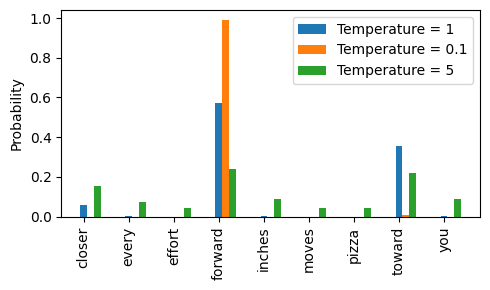

In [59]:
import matplotlib.pyplot as plt
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], 
                    bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


Una  temperatura  de  1  divide  los  logits  entre  1  antes  de  pasarlos  a  la  función  softmax  para  calcular  las  puntuaciones  de  probabilidad.  En  otras  palabras,  usar  una  temperatura  de  1  equivale  a  no  usar  escala  de  temperatura.  En  este  caso,  los  tokens  se  seleccionan  con  una  probabilidad  igual  a  las  puntuaciones  de  probabilidad  softmax  originales  mediante  la  función  de  muestreo  multinomial  de  PyTorch.

Además,  como  se  observa  en  la  Figura,  aplicar  temperaturas  muy  pequeñas,  como  0,1,  dará  como  resultado  distribuciones  más  nítidas,  de  modo  que  el  comportamiento  de  la  función  multinomial  selecciona  el  token  más  probable  (en  este  caso:  "forward")  casi  el  100  %  de  las  veces,  acercándose  al  comportamiento  de  la  función  argmax.  Por  el  contrario,  una  temperatura  de  5  da  como  resultado  una  distribución  más  uniforme,  donde  se  seleccionan  otros  tokens  con  mayor  frecuencia.  Esto  puede  añadir  más  variedad  a  los  textos  generados,  pero  también  suele  generar  texto  sin  sentido.  Por  ejemplo,  usar  una  temperatura  de  5  da  como  resultado  textos  como  "every effort moves you pizza"  aproximadamente  el  4  %  deel  tiempo.

### 3.2 Muestreo de lo mejores k (top-k)

En la sección anterior, se implementó un enfoque de muestreo probabilístico combinado con el escalamiento de temperatura para aumentar la diversidad de los resultados generados. Se observó que valores de temperatura más altos aplanan la distribución de probabilidad, resultando en una selección de tokens más uniforme.

Este método permite al modelo explorar caminos menos probables, pero potencialmente más interesantes y creativos, ya que reduce la tendencia a seleccionar repetidamente el token más probable.

Sin embargo, una desventaja notable de este enfoque es que, al aumentar la aleatoriedad, a veces genera resultados gramaticalmente incorrectos o completamente sin sentido.

Para solucionar el problema anterior y mejorar la calidad de la generación, en esta sección se introduce el concepto de muestreo top-k.

El objetivo de esta técnica es restringir el proceso de muestreo únicamente a los k tokens más probables. Todos los demás tokens (los menos probables) son excluidos del proceso de selección mediante el enmascaramiento de sus puntuaciones de probabilidad.

Al combinar el muestreo top-k con el escalamiento de temperatura, es posible mantener un buen nivel de diversidad, pero limitando las opciones a un conjunto de candidatos que ya son plausibles, mejorando así la coherencia y la calidad general del texto generado.

![Texto alternativo](./imgs/5.13.png)

El  enfoque  descrito  en  la  Figura  reemplaza  todos  los  logits  no  seleccionados  con  valor  infinito  negativo  ( inf),  de  modo  que  al  calcular  los  valores  softmax,  los  puntajes  de  probabilidad  de  los  tokens  que  no  son  topk  son  0  y  las  probabilidades  restantes  suman  1. 

In [60]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, k=top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Posteriormente,  se aplica la  función  where  de  PyTorch  para  establecer  los  valores  logit  de  los  tokens  que  están  por  debajo  del  valor  logit  más  bajo  dentro  de  nuestra  selección  top3  en  infinito  negativo  (-inf).

In [ ]:
new_logits = torch.where(condition=next_token_logits < top_logits[-1], #Identifica  logits  menores  al  mínimo  en  el  top  3
                        input=torch.tensor(float('-inf')),  #Asigna  inf  a  estos  logits  inferiores
                        other=next_token_logits)    #Conserva  los  logits  originales  para  todos  los  demás  tokens
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Por  último,  se aplica  la  función  softmax  para  convertirlas  en  probabilidades  del  próximo  token.

In [62]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


El  resultado  de  este  enfoque  de  los  3  mejores  son  3  puntuaciones  de  probabilidad  distintas  de  cero